<a href="https://colab.research.google.com/github/SJG0510/ML-Project/blob/main/Heal_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


서울의 예상 흡연율 (2025년): 13.60%
서울의 예상 흡연율 (2026년): 12.96%


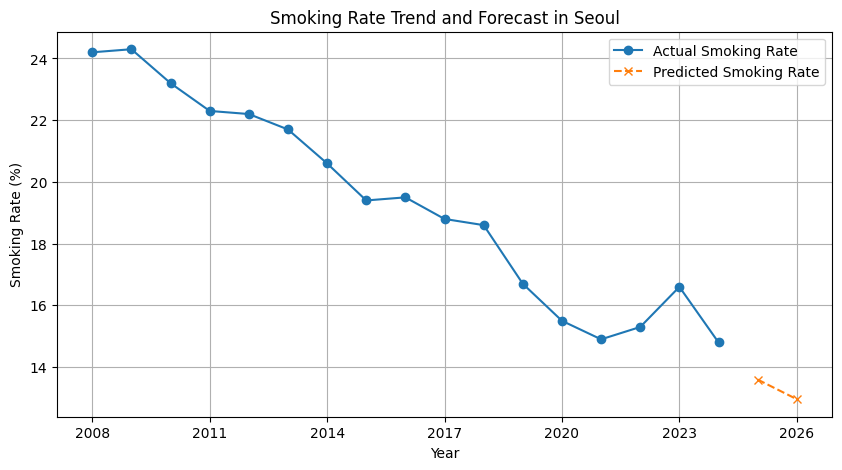

In [ ]:
# 1. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression

# 3. 파일 경로 및 엑셀 파일 로드
file_path = '/content/drive/MyDrive/Health/2024년_3-1.부록(시도별)-(1)건강행태.xlsx'
xls = pd.ExcelFile(file_path)

# 4. C12:W199 범위의 원본 데이터 불러오기 함수
def load_original_range(sheet_name):
    df = xls.parse(sheet_name, skiprows=11, usecols="C:W", nrows=188)
    df.columns = df.columns.astype(str)
    return df

# 5. 흡연율 시트 로딩 및 전처리
df_smoking = load_original_range('1.현재흡연')
df_smoking['시도'] = df_smoking['구분'].ffill()  # 시도명 보간
df_smoking['구분'] = df_smoking['Unnamed: 3'].astype(str).str.strip()
df_smoking['단위'] = df_smoking['Unnamed: 4'].astype(str).str.strip()

# 6. '전체' + '(조율)' 조건의 흡연율 데이터만 추출
year_cols = [str(y) for y in range(2008, 2025)]
data = []

for _, row in df_smoking.iterrows():
    if row['구분'] == '전체' and row['단위'] == '(조율)':
        for year in year_cols:
            val = row[year]
            if isinstance(val, str):
                match = re.match(r"([\d\.]+)\(([\d\.]+)\)", val)
                if match:
                    data.append({
                        '시도': row['시도'],
                        '연도': int(year),
                        '흡연율': float(match.group(1))
                    })

df_clean = pd.DataFrame(data)

# 7. 서울시 흡연율 시계열 데이터 추출 및 모델 학습
seoul_data = df_clean[df_clean['시도'] == '서울']
X = seoul_data[['연도']]
y = seoul_data['흡연율']

model = LinearRegression()
model.fit(X, y)

# 8. 향후 흡연율 예측 (2025, 2026년)
future_years = np.array([[2025], [2026]])
future_preds = model.predict(future_years)

# 9. 예측 결과 출력
for year, pred in zip(future_years.flatten(), future_preds):
    print(f"서울의 예상 흡연율 ({year}년): {pred:.2f}%")

# 10. 시각화
plt.figure(figsize=(10, 5))
plt.plot(X, y, label='Actual Smoking Rate', marker='o')
plt.plot(future_years, future_preds, label='Predicted Smoking Rate', marker='x', linestyle='--')
plt.title('Smoking Rate Trend and Forecast in Seoul')
plt.xlabel('Year')
plt.ylabel('Smoking Rate (%)')
plt.legend()
plt.grid(True)

# x축 연도 눈금 설정 (3년 간격)
start_year = seoul_data['연도'].min()
end_year = 2026
plt.xticks(range(start_year, end_year + 1, 3))

plt.show()
